In [1]:
import pickle   #specialized format for data
import numpy as np

In [2]:
with open('train_qa.txt', 'rb') as f:   #read as binary
    train_data = pickle.load(f)

In [3]:
with open('test_qa.txt', 'rb') as f:   #read as binary
    test_data = pickle.load(f)

10000 points for trainig data and <br>
1000 points for test data <br>
each training example is a tuple (story, question, answer)

In [4]:
'''
Creating the vocabulary
'''
all_data = test_data + train_data
vocab = set()   #set is an unordered list of unique elements

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
    vocab.add('no')
    vocab.add('yes')
    
vocab_len = len(vocab) + 1   #we will use it later
print(vocab_len)

38


In [5]:
'''
We want to the longest story for later use
'''
all_story_lens = [len(data[0]) for data in all_data]
max_story_len = max(all_story_lens)
print(max_story_len)

156


In [6]:
'''
We want to the longest question for later use
'''
all_question_lens = [len(data[1]) for data in all_data]
max_question_len = max(all_question_lens)
print(max_question_len)

6


In [7]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [8]:
'''
Create a dictionary that maps every word of the vocabularu to an index
'''
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

tokenizer.word_index

{'hallway': 1,
 'bathroom': 2,
 'there': 3,
 'is': 4,
 'back': 5,
 'journeyed': 6,
 'got': 7,
 'to': 8,
 'put': 9,
 'sandra': 10,
 'no': 11,
 'office': 12,
 'picked': 13,
 'moved': 14,
 'went': 15,
 'discarded': 16,
 'grabbed': 17,
 'up': 18,
 'football': 19,
 'kitchen': 20,
 'john': 21,
 'milk': 22,
 'mary': 23,
 'apple': 24,
 'left': 25,
 'the': 26,
 'bedroom': 27,
 'garden': 28,
 'in': 29,
 'yes': 30,
 'dropped': 31,
 '?': 32,
 'took': 33,
 'daniel': 34,
 '.': 35,
 'travelled': 36,
 'down': 37}

In [9]:
'''
Make lists of stories, qustions and answers
'''
train_story_text = []
train_question_text = []
train_answer_text = []

for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answer_text.append(answer)

In [10]:
'''
Same for test_data
'''
test_story_text = []
test_question_text = []
test_answer_text = []

for story, question, answer in test_data:
    test_story_text.append(story)
    test_question_text.append(question)
    test_answer_text.append(answer)

In [11]:
'''
-----CREATE PADDED SEQUENCIES-----
VECTORIZING: Conververting words -> indexes,
             sentences -> sequencies of integers
PADDING: Padding vectors with zeros
'''
train_story_seq = tokenizer.texts_to_sequences(train_story_text)
train_story_seq = pad_sequences(train_story_seq, maxlen=max_story_len)

train_question_seq = tokenizer.texts_to_sequences(train_question_text)
train_question_seq = pad_sequences(train_question_seq, maxlen=max_question_len)

In [12]:
'''
Same for test data
'''
test_story_seq = tokenizer.texts_to_sequences(test_story_text)
test_story_seq = pad_sequences(test_story_seq, maxlen=max_story_len)

test_question_seq = tokenizer.texts_to_sequences(test_question_text)
test_question_seq = pad_sequences(test_question_seq, maxlen=max_question_len)

In [13]:
print(f'Index of "yes" is: {tokenizer.word_index.get("yes")}')
print(f'Index of "no" is:  {tokenizer.word_index.get("no")}')

Index of "yes" is: 30
Index of "no" is:  11


In [14]:
'''
Converting train and test answers to one hot representation
'''
train_answer_oh = np.zeros(shape=(len(train_data), vocab_len))
test_answer_oh = np.zeros(shape=(len(train_data), vocab_len))

m = len(train_data)   #m is the number of training examples

for i in range(m):   #i is the trainining example
    train_answer_oh[i][tokenizer.word_index.get(train_answer_text[i])] = 1

y = len(test_data)
for i in range(y):
    test_answer_oh[i][tokenizer.word_index.get(test_answer_text[i])] = 1


In [15]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM

In [16]:
# PLACEHOLDER shape=(max_story_len, batch_size)
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [17]:
# INPUT ENCODER M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len, output_dim=64))
input_encoder_m.add(Dropout(0.33))

# OUTPUT
# (m, max_story_len, embedding_dim)

In [18]:
# INPUT ENCODER C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.33))

# OUTPUT
# (m, max_story_len, max_question_len)

In [19]:
# QUESTION ENCODER
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_len, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.33))

# OUTPUT
# (m, max_question_len, embedding_dim)

In [20]:
# ENCODED --> ENCODER(INPUT)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded= question_encoder(question)

In [21]:
match = dot([input_encoded_m, question_encoded], axes=(2,2))
match = Activation('softmax')(match)

In [22]:
response = add([match, input_encoded_c])
print(response.shape)
response = Permute((2,1))(response)   #changes the axes
print(response.shape)

(None, 156, 6)
(None, 6, 156)


In [23]:
question_encoded.shape

TensorShape([None, 6, 64])

In [24]:
answer = concatenate([response, question_encoded])
answer.shape

TensorShape([None, 6, 220])

In [25]:
answer = LSTM(units=32)(answer)

In [26]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_len)(answer)   #(samples,vocab_size)
answer

<tf.Tensor 'dense_1/BiasAdd:0' shape=(None, 38) dtype=float32>

In [27]:
answer = Activation('softmax')(answer)

In [28]:
model = Model([input_sequence,question], answer)

In [29]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
____________________________________________________________________________________________

In [31]:
history = model.fit([train_story_seq, train_question_seq], train_answer_oh, batch_size=50, epochs=200)

/home/kaml/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/200
10000/10000 [==============================] - 5s 545us/step - loss: 1.0383 - accuracy: 0.4897
Epoch 2/200
10000/10000 [==============================] - 4s 438us/step - loss: 0.7178 - accuracy: 0.5071
Epoch 3/200
10000/10000 [==============================] - 4s 375us/step - loss: 0.6986 - accuracy: 0.5063
Epoch 4/200
10000/10000 [==============================] - 4s 403us/step - loss: 0.6964 - accuracy: 0.4911
Epoch 5/200
10000/10000 [==============================] - 4s 392us/step - loss: 0.6946 - accuracy: 0.5012
Epoch 6/200
10000/10000 [==============================] - 4s 390us/step - loss: 0.6949 - accuracy: 0.4930
Epoch 7/200
10000/10000 [==============================] - 4s 365us/step - loss: 0.6943 - accuracy: 0.5033
Epoch 8/200
10000/10000 [==============================] - 4s 376us/step - loss: 0.6944 - accuracy: 0.5059
Epoch 9/200
10000/10000 [==============================] - 4s 368us/step - loss: 0.6947 - accuracy: 0.4956
Epoch 10/200
10000/10000 [===========

Epoch 77/200
10000/10000 [==============================] - 4s 386us/step - loss: 0.2665 - accuracy: 0.8816
Epoch 78/200
10000/10000 [==============================] - 4s 369us/step - loss: 0.2602 - accuracy: 0.8847
Epoch 79/200
10000/10000 [==============================] - 4s 360us/step - loss: 0.2659 - accuracy: 0.8849
Epoch 80/200
10000/10000 [==============================] - 4s 367us/step - loss: 0.2619 - accuracy: 0.8833
Epoch 81/200
10000/10000 [==============================] - 4s 374us/step - loss: 0.2635 - accuracy: 0.8834
Epoch 82/200
10000/10000 [==============================] - 4s 378us/step - loss: 0.2577 - accuracy: 0.8865
Epoch 83/200
10000/10000 [==============================] - 4s 379us/step - loss: 0.2563 - accuracy: 0.8889
Epoch 84/200
10000/10000 [==============================] - 4s 378us/step - loss: 0.2559 - accuracy: 0.8905
Epoch 85/200
10000/10000 [==============================] - 4s 372us/step - loss: 0.2597 - accuracy: 0.8866
Epoch 86/200
10000/10000 [==

10000/10000 [==============================] - 4s 422us/step - loss: 0.1753 - accuracy: 0.9241
Epoch 153/200
10000/10000 [==============================] - 4s 374us/step - loss: 0.1700 - accuracy: 0.9268
Epoch 154/200
10000/10000 [==============================] - 4s 359us/step - loss: 0.1735 - accuracy: 0.9256
Epoch 155/200
10000/10000 [==============================] - 4s 420us/step - loss: 0.1791 - accuracy: 0.9276
Epoch 156/200
10000/10000 [==============================] - 4s 420us/step - loss: 0.1677 - accuracy: 0.9290
Epoch 157/200
10000/10000 [==============================] - 4s 388us/step - loss: 0.1729 - accuracy: 0.9267
Epoch 158/200
10000/10000 [==============================] - 4s 394us/step - loss: 0.1694 - accuracy: 0.9290
Epoch 159/200
10000/10000 [==============================] - 4s 404us/step - loss: 0.1633 - accuracy: 0.9337
Epoch 160/200
10000/10000 [==============================] - 4s 393us/step - loss: 0.1633 - accuracy: 0.9328
Epoch 161/200
10000/10000 [======

In [32]:
# filename = 'chatbot_120_epochs.h5'
filename = 'chatbot_200_epochs.h5'
model.save(filename)

In [33]:
from keras.models import load_model

In [34]:
model = load_model('chatbot_200_epochs.h5')

/home/kaml/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


dict_keys(['loss', 'accuracy'])


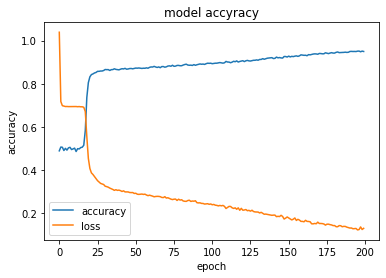

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accyracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'loss'])
plt.show()

In [37]:
predictions = model.predict([test_story_seq, test_question_seq])

In [38]:
predictions.shape

(1000, 38)

In [39]:
predicted_answers = []
for i in range(len(test_data)):
    val_max = np.argmax(predictions[i])
    for key, val in tokenizer.word_index.items():
        if val == val_max:
            predicted_answers.append(key)

In [40]:
for i in range(len(test_data)):   
    if predicted_answers[i] == 'yes':
        predicted_answers[i] = 1.0
    else:
        predicted_answers[i] = 0.0

In [41]:
for i in range(len(test_data)):   
    if test_answer_text[i] == 'yes':
        test_answer_text[i] = 1.0
    else:
        test_answer_text[i] = 0.0

In [42]:
correct_ans = 0
for i in range(len(test_data)):
    if predicted_answers[i] == test_answer_text[i]:
        correct_ans += 1
        
accuracy = correct_ans / len(test_data)
print(accuracy)

0.865


In [52]:
my_story = [[]]   #ATTENTION!!! Must be a list of lists
my_story[0] = ("John is in the kitchen.").split()
my_story_seq = tokenizer.texts_to_sequences(my_story)
my_story_seq = pad_sequences(my_story_seq, maxlen=max_story_len)

In [54]:
my_question = [[]]
my_question[0] = ('Is John in the bathroom?').split()
my_question_seq = tokenizer.texts_to_sequences(my_question)
my_question_seq = pad_sequences(my_question_seq, maxlen=max_question_len)

In [55]:
my_prediction = model.predict([my_story_seq, my_question_seq])

In [56]:
my_prediction.shape

(1, 38)

In [57]:
my_val_max = np.argmax(my_prediction)
my_val_max

30

In [58]:
for key, val in tokenizer.word_index.items():
    if val == my_val_max:
        k = key
print(k)

yes


**FAIL**